In [1]:
import cv2
import numpy as np
from pathlib import Path

In [2]:
# Path to video file
video_path = Path("data/videos/test_video_3.mp4")

# Initialize video capture
cap = cv2.VideoCapture(str(video_path))

if not cap.isOpened():
    raise ValueError(f"Cannot open video: {video_path}")

# Get video properties
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video: {n_frames} frames, {fps:.2f} FPS, {width}x{height}")

Video: 756 frames, 30.00 FPS, 848x464


In [3]:
# Feature tracking parameters for Lucas-Kanade optical flow
lk_params = dict(
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

# Good features to track parameters
feature_params = dict(
    maxCorners=200,
    qualityLevel=0.01,
    minDistance=30,
    blockSize=3
)

# Read first frame
ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Cannot read first frame")

prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Pre-define transformation-store array (dx, dy, da)
transforms = np.zeros((n_frames - 1, 3), np.float32)

print("Starting feature tracking with Lucas-Kanade optical flow...")

Starting feature tracking with Lucas-Kanade optical flow...


In [4]:
# Compute optical flow and extract transforms
for i in range(n_frames - 2):
    # Detect feature points in previous frame
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, **feature_params)
    
    if prev_pts is None:
        print(f"Frame {i}: No features detected, skipping")
        continue
    
    # Read next frame
    ret, curr_frame = cap.read()
    if not ret:
        break
    
    # Convert to grayscale
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    # Calculate optical flow (track feature points) using Lucas-Kanade
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, prev_pts, None, **lk_params
    )
    
    # Filter only valid points
    idx = np.where(status == 1)[0]
    prev_pts_valid = prev_pts[idx]
    curr_pts_valid = curr_pts[idx]
    
    if len(prev_pts_valid) < 4:
        print(f"Frame {i}: Not enough valid points ({len(prev_pts_valid)}), skipping")
        prev_gray = curr_gray
        continue
    
    # Find transformation matrix (OpenCV 4 compatible)
    m, inliers = cv2.estimateAffinePartial2D(prev_pts_valid, curr_pts_valid)
    
    if m is not None:
        # Extract translation
        dx = m[0, 2]
        dy = m[1, 2]
        
        # Extract rotation angle
        da = np.arctan2(m[1, 0], m[0, 0])
        
        # Store transformation
        transforms[i] = [dx, dy, da]
    
    # Move to next frame
    prev_gray = curr_gray
    
    if (i + 1) % 50 == 0:
        print(f"Frame: {i + 1}/{n_frames} - Tracked points: {len(prev_pts_valid)}")

print(f"\nFeature tracking complete. Processed {i + 1} frames.")

Frame: 50/756 - Tracked points: 200
Frame: 100/756 - Tracked points: 147
Frame: 150/756 - Tracked points: 158
Frame: 200/756 - Tracked points: 195
Frame: 250/756 - Tracked points: 199
Frame: 300/756 - Tracked points: 200
Frame: 350/756 - Tracked points: 200
Frame: 400/756 - Tracked points: 199
Frame: 450/756 - Tracked points: 198
Frame: 500/756 - Tracked points: 200
Frame: 550/756 - Tracked points: 188
Frame: 600/756 - Tracked points: 197
Frame: 650/756 - Tracked points: 198
Frame: 700/756 - Tracked points: 198
Frame: 750/756 - Tracked points: 200

Feature tracking complete. Processed 754 frames.


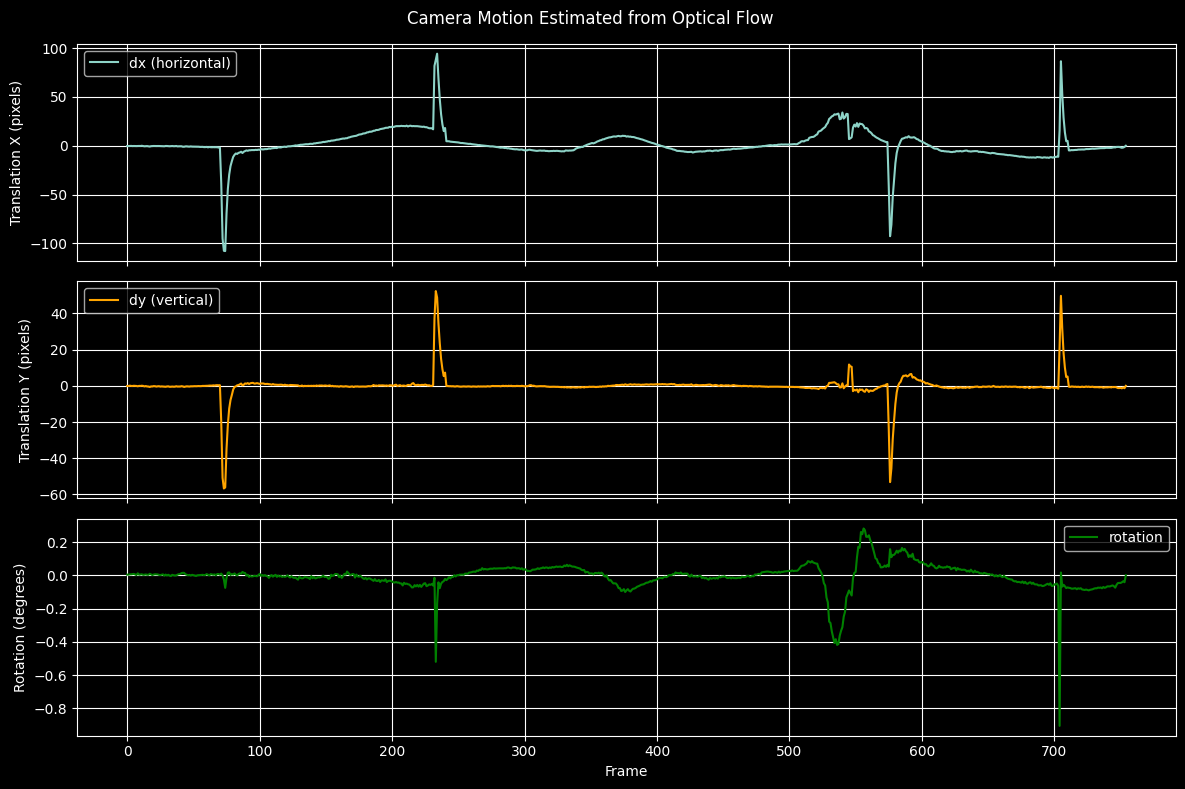

Max translation: dx=94.37, dy=52.33
Max rotation: 0.28 degrees


In [5]:
import matplotlib.pyplot as plt

# Visualize the computed transforms
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(transforms[:, 0], label='dx (horizontal)')
axes[0].set_ylabel('Translation X (pixels)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(transforms[:, 1], label='dy (vertical)', color='orange')
axes[1].set_ylabel('Translation Y (pixels)')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(np.degrees(transforms[:, 2]), label='rotation', color='green')
axes[2].set_ylabel('Rotation (degrees)')
axes[2].set_xlabel('Frame')
axes[2].legend()
axes[2].grid(True)

plt.suptitle('Camera Motion Estimated from Optical Flow')
plt.tight_layout()
plt.show()

print(f"Max translation: dx={transforms[:, 0].max():.2f}, dy={transforms[:, 1].max():.2f}")
print(f"Max rotation: {np.degrees(transforms[:, 2].max()):.2f} degrees")

In [6]:
# Define feature detectors
def get_features_shi_tomasi(gray):
    pts = cv2.goodFeaturesToTrack(gray, **feature_params)
    return pts

def get_features_sift(gray):
    sift = cv2.SIFT_create(nfeatures=200)
    keypoints = sift.detect(gray)
    if len(keypoints) == 0:
        return None
    pts = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)
    return pts

def get_features_orb(gray):
    orb = cv2.ORB_create(nfeatures=200)
    keypoints = orb.detect(gray)
    if len(keypoints) == 0:
        return None
    pts = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)
    return pts

def get_features_fast(gray):
    fast = cv2.FastFeatureDetector_create(threshold=20)
    keypoints = fast.detect(gray)
    if len(keypoints) == 0:
        return None
    # Limit to 200 strongest points
    keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)[:200]
    pts = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)
    return pts

# Feature detectors to test
detectors = {
    'shi_tomasi': get_features_shi_tomasi,
    'sift': get_features_sift,
    'orb': get_features_orb,
    'fast': get_features_fast
}

print(f"Testing {len(detectors)} feature detectors: {list(detectors.keys())}")

Testing 4 feature detectors: ['shi_tomasi', 'sift', 'orb', 'fast']


In [7]:
# Process video with each feature detector
output_dir = Path("data")

for detector_name, get_features in detectors.items():
    print(f"\n{'='*50}")
    print(f"Processing with: {detector_name.upper()}")
    print('='*50)
    
    # Create output directories for this detector
    features_dir = output_dir / f"{detector_name}_features_frames"
    movement_dir = output_dir / f"{detector_name}_movement_frames"
    features_dir.mkdir(parents=True, exist_ok=True)
    movement_dir.mkdir(parents=True, exist_ok=True)
    
    # Reset video capture
    cap = cv2.VideoCapture(str(video_path))
    
    # Read first frame
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    
    # Detect and draw features on first frame
    first_pts = get_features(prev_gray)
    first_frame_features = prev_frame.copy()
    if first_pts is not None:
        for pt in first_pts:
            x, y = int(pt[0][0]), int(pt[0][1])
            cv2.circle(first_frame_features, (x, y), 5, (0, 255, 255), -1)
    
    # Save first frame
    cv2.imwrite(str(features_dir / "frame_0000.png"), first_frame_features)
    cv2.imwrite(str(movement_dir / "frame_0000.png"), prev_frame)
    
    frame_idx = 1
    
    while True:
        ret, curr_frame = cap.read()
        if not ret:
            break
        
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        
        # Detect features in current frame
        curr_features = get_features(curr_gray)
        
        # Frame with all detected features (yellow circles)
        frame_with_features = curr_frame.copy()
        if curr_features is not None:
            for pt in curr_features:
                x, y = int(pt[0][0]), int(pt[0][1])
                cv2.circle(frame_with_features, (x, y), 5, (0, 255, 255), -1)
        
        # Detect features in previous frame for tracking
        prev_pts = get_features(prev_gray)
        
        # Frame with top movement points
        frame_with_movement = curr_frame.copy()
        
        if prev_pts is not None:
            # Track points using Lucas-Kanade
            curr_pts, status, err = cv2.calcOpticalFlowPyrLK(
                prev_gray, curr_gray, prev_pts, None, **lk_params
            )
            
            # Calculate movements for valid points
            movements = []
            valid_idx = np.where(status == 1)[0]
            
            for idx in valid_idx:
                prev_pt = prev_pts[idx][0]
                curr_pt = curr_pts[idx][0]
                dx = curr_pt[0] - prev_pt[0]
                dy = curr_pt[1] - prev_pt[1]
                magnitude = np.sqrt(dx**2 + dy**2)
                movements.append((prev_pt, curr_pt, magnitude))
            
            # Sort by magnitude and get top 5
            movements.sort(key=lambda x: x[2], reverse=True)
            top_5 = movements[:5]
            
            # Draw top 5 points on the frame
            for rank, (prev_pt, curr_pt, mag) in enumerate(top_5, 1):
                px, py = int(prev_pt[0]), int(prev_pt[1])
                cx, cy = int(curr_pt[0]), int(curr_pt[1])
                
                # Draw arrow from previous to current position
                cv2.arrowedLine(frame_with_movement, (px, py), (cx, cy), (0, 255, 0), 2, tipLength=0.3)
                
                # Draw circle at current position
                cv2.circle(frame_with_movement, (cx, cy), 8, (0, 0, 255), -1)
                
                # Draw rank label
                cv2.putText(frame_with_movement, f"#{rank}", (cx + 10, cy - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        
        # Save frames
        cv2.imwrite(str(features_dir / f"frame_{frame_idx:04d}.png"), frame_with_features)
        cv2.imwrite(str(movement_dir / f"frame_{frame_idx:04d}.png"), frame_with_movement)
        
        prev_gray = curr_gray
        frame_idx += 1
        
        if frame_idx % 200 == 0:
            print(f"  Processed {frame_idx}/{n_frames} frames")
    
    cap.release()
    print(f"  Saved {frame_idx} frames to {features_dir.name}/ and {movement_dir.name}/")

print(f"\n{'='*50}")
print("All detectors processed!")
print('='*50)


Processing with: SHI_TOMASI
  Processed 200/756 frames
  Processed 400/756 frames
  Processed 600/756 frames
  Saved 756 frames to shi_tomasi_features_frames/ and shi_tomasi_movement_frames/

Processing with: SIFT
  Processed 200/756 frames
  Processed 400/756 frames
  Processed 600/756 frames
  Saved 756 frames to sift_features_frames/ and sift_movement_frames/

Processing with: ORB
  Processed 200/756 frames
  Processed 400/756 frames
  Processed 600/756 frames
  Saved 756 frames to orb_features_frames/ and orb_movement_frames/

Processing with: FAST
  Processed 200/756 frames
  Processed 400/756 frames
  Processed 600/756 frames
  Saved 756 frames to fast_features_frames/ and fast_movement_frames/

All detectors processed!


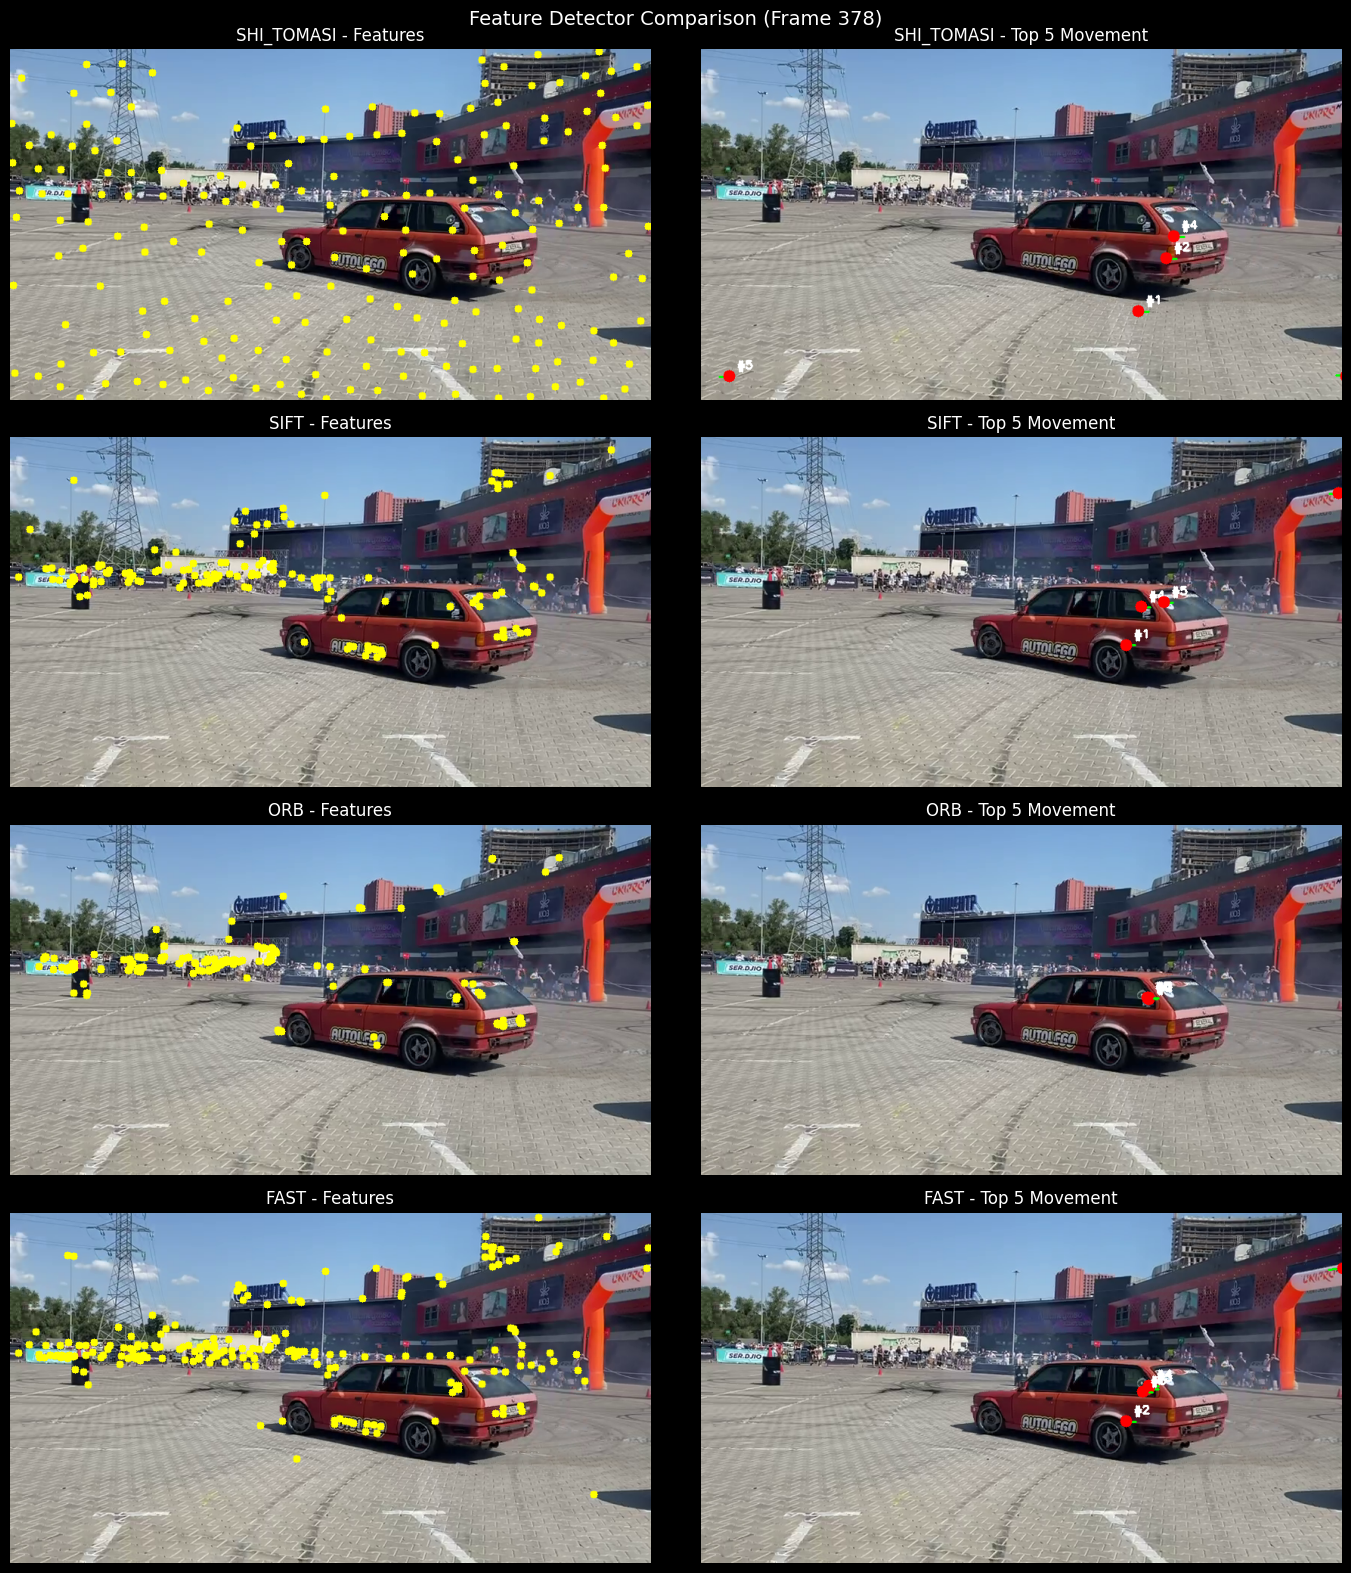


Output folders created:
  - data/shi_tomasi_features_frames/
  - data/shi_tomasi_movement_frames/
  - data/sift_features_frames/
  - data/sift_movement_frames/
  - data/orb_features_frames/
  - data/orb_movement_frames/
  - data/fast_features_frames/
  - data/fast_movement_frames/


In [8]:
# Display comparison of all detectors on a sample frame
sample_frame_idx = n_frames // 2

fig, axes = plt.subplots(4, 2, figsize=(14, 16))

for row, detector_name in enumerate(detectors.keys()):
    features_path = output_dir / f"{detector_name}_features_frames" / f"frame_{sample_frame_idx:04d}.png"
    movement_path = output_dir / f"{detector_name}_movement_frames" / f"frame_{sample_frame_idx:04d}.png"
    
    if features_path.exists():
        feat_img = cv2.imread(str(features_path))
        axes[row, 0].imshow(cv2.cvtColor(feat_img, cv2.COLOR_BGR2RGB))
    axes[row, 0].set_title(f"{detector_name.upper()} - Features")
    axes[row, 0].axis('off')
    
    if movement_path.exists():
        mov_img = cv2.imread(str(movement_path))
        axes[row, 1].imshow(cv2.cvtColor(mov_img, cv2.COLOR_BGR2RGB))
    axes[row, 1].set_title(f"{detector_name.upper()} - Top 5 Movement")
    axes[row, 1].axis('off')

plt.suptitle(f"Feature Detector Comparison (Frame {sample_frame_idx})", fontsize=14)
plt.tight_layout()
plt.show()

print("\nOutput folders created:")
for detector_name in detectors.keys():
    print(f"  - data/{detector_name}_features_frames/")
    print(f"  - data/{detector_name}_movement_frames/")